
# Model 1 training ($E_{cm} = 100$ GeV)


In [12]:
# ─── Mount Google Drive ─────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive')  # Mount Google Drive for file access

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# ─── Standard Libraries ─────────────────────────────────────────────────────────
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ─── Scikit-learn: Train-Test Split, Metrics, Class Balancing ───────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc  # ROC and AUC score
from sklearn.utils.class_weight import compute_class_weight  # Handle class imbalance

# ─── TensorFlow and Keras Libraries ─────────────────────────────────────────────
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Training callbacks
from tensorflow.keras.metrics import AUC, Precision, Recall  # Additional metrics

In [14]:
# ─── Define Key File Paths ──────────────────────────────────────────────────────
drive_dir = Path('/content/drive/MyDrive/Jet_classification_project/Training_Datasets_Models_Results')

# Load input image and label files
jet_images_path = drive_dir / 'Dataset1_75k_100GeV/jet_images.npy'
jet_labels_path = drive_dir / 'Dataset1_75k_100GeV/jet_labels.npy'

# Path to save the trained model
model_save_path = drive_dir / 'Dataset1_Model_and_Results/Model1_100GeV.keras'

# Directory to save evaluation plots, logs, etc.
metrics_path = drive_dir / 'Dataset1_Model_and_Results'

In [15]:
# ─── Load Jet Images and Labels ────────────────────────────────────────────────
X = np.load(jet_images_path)  # Load the jet image dataset (NumPy array)
y = np.load(jet_labels_path)  # Load corresponding labels (0 for quark, 1 for tau)

# ─── Ensure Channel Dimension Exists ───────────────────────────────────────────
if len(X.shape) == 3:
    X = X[..., np.newaxis]  # Add a channel dimension if missing → shape: (N, H, W, 1)

# ─── Get Input Image Shape for Model ───────────────────────────────────────────
input_shape = X.shape[1:]  # e.g., (32, 32, 1)

# ─── Print Dataset Summary ─────────────────────────────────────────────────────
print(f"Loaded {X.shape[0]} jet images with shape {input_shape} and {len(np.unique(y))} classes.")
print(f"Labels shape: {y.shape}\n")

# ─── Check Image Value Ranges ──────────────────────────────────────────────────
print(f"Final Images shape: {X.shape}")
print(f"Pixel Intensity Range: Min = {X.min()}, Max = {X.max()}")


Loaded 222778 jet images with shape (32, 32, 1) and 2 classes.
Labels shape: (222778,)

Final Images shape: (222778, 32, 32, 1)
Pixel Intensity Range: Min = 0.0, Max = 1.0


In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=31, stratify=y)

print(f"Train set:      {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

Train set:      155944 samples
Validation set: 66834 samples


In [17]:
# ─── Define the CNN Architecture ───────────────────────────────────────────────
model = models.Sequential()

# Input layer (expects images with the shape determined earlier)
model.add(layers.Input(shape=input_shape))

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))  # 32 filters, 3x3 kernel
model.add(layers.BatchNormalization())                                  # Normalize activations
model.add(layers.MaxPooling2D((2, 2)))                                   # Downsample by 2x

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))  # 64 filters
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional block
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same')) # 128 filters
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))

# Fourth convolutional block (no pooling)
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.BatchNormalization())

# Flatten to transition to fully connected layers
model.add(layers.Flatten())

# Dense (fully connected) layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout to reduce overfitting

# Output layer (binary classification: sigmoid for probability output)
model.add(layers.Dense(1, activation='sigmoid'))

# Show model architecture summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,065 (1.92 MB)

 Trainable params: 503,361 (1.92 MB)

 Non-trainable params: 704 (2.75 KB)

In [18]:
# ─── Define Learning Rate Schedule ─────────────────────────────────────────────
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,  # Starting learning rate
    decay_steps=1500,            # Number of steps before applying decay
    decay_rate=0.95              # Learning rate decay factor
)

# Use Adam optimizer with the defined learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# ─── Compute Class Weights to Handle Imbalance ────────────────────────────────
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

# ─── Compile the CNN Model ────────────────────────────────────────────────────
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',  # Suitable for binary classification
    metrics=[
        'accuracy',
        AUC(name='auc'),          # Area Under ROC Curve
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

print("\nModel Compiled Successfully!\n")

# ─── Define Callbacks ─────────────────────────────────────────────────────────
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor validation loss
    patience=15,                # Stop if no improvement for 15 epochs
    restore_best_weights=True  # Revert to best model after stopping
)

checkpoint = ModelCheckpoint(
    model_save_path,           # Save path
    monitor='val_loss',
    save_best_only=True        # Save only the best version
)

# ─── Training Parameters ───────────────────────────────────────────────────────
batch_size = 64
epochs = 120

# ─── Train the Model ───────────────────────────────────────────────────────────
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,   # Apply class weights
    callbacks=[early_stopping, checkpoint]  # Use callbacks
)

print(f"\nModel saved to {model_save_path}")

Class Weights: {0: np.float64(1.1338413215449046), 1: np.float64(0.894420482701661)}

Model Compiled Successfully!

Epoch 1/120
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.8258 - auc: 0.8900 - loss: 0.4098 - precision: 0.8359 - recall: 0.8575 - val_accuracy: 0.9095 - val_auc: 0.9627 - val_loss: 0.2428 - val_precision: 0.9133 - val_recall: 0.9259
Epoch 2/120
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 32s 7ms/step - accuracy: 0.9043 - auc: 0.9572 - loss: 0.2559 - precision: 0.9058 - recall: 0.9248 - val_accuracy: 0.9156 - val_auc: 0.9691 - val_loss: 0.2271 - val_precision: 0.9352 - val_recall: 0.9121
Epoch 3/120
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.9150 - auc: 0.9649 - loss: 0.2304 - precision: 0.9168 - recall: 0.9319 - val_accuracy: 0.9240 - val_auc: 0.9717 - val_loss: 0.2019 - val_precision: 0.9218 - val_recall: 0.9442
Epoch 4/120
2437/2437 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.9209 - auc: 0.9677 - loss: 0.2184 - precision: 0.9218 - recall: 0.9380 - val

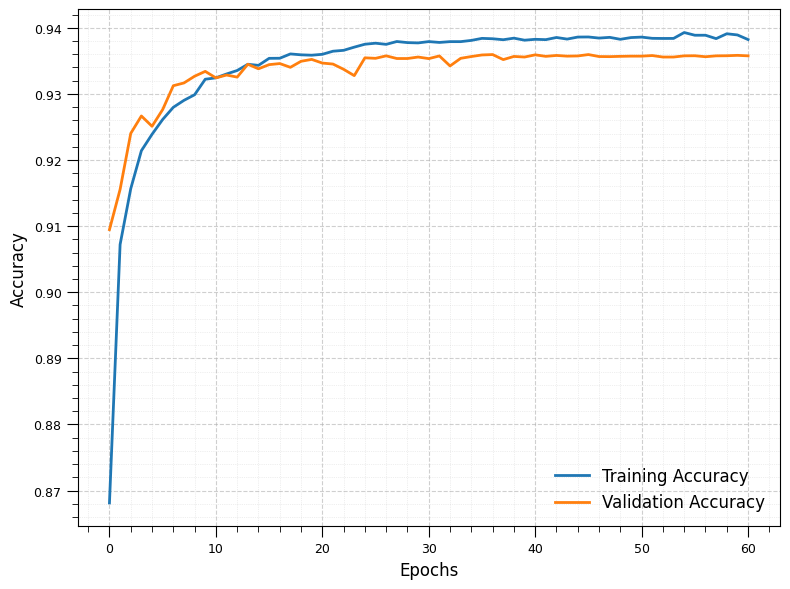

In [19]:
# Accuracy Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', lw=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', lw=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.minorticks_on()

plt.tick_params(axis='both', which='major', length=8)
plt.tick_params(axis='both', which='minor', length=4)

plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

plt.legend(loc='best', fontsize=12, frameon=False)
plt.tight_layout()

plt.savefig(f'{metrics_path}/training_vs_val_acc.png', dpi=300)
plt.show()

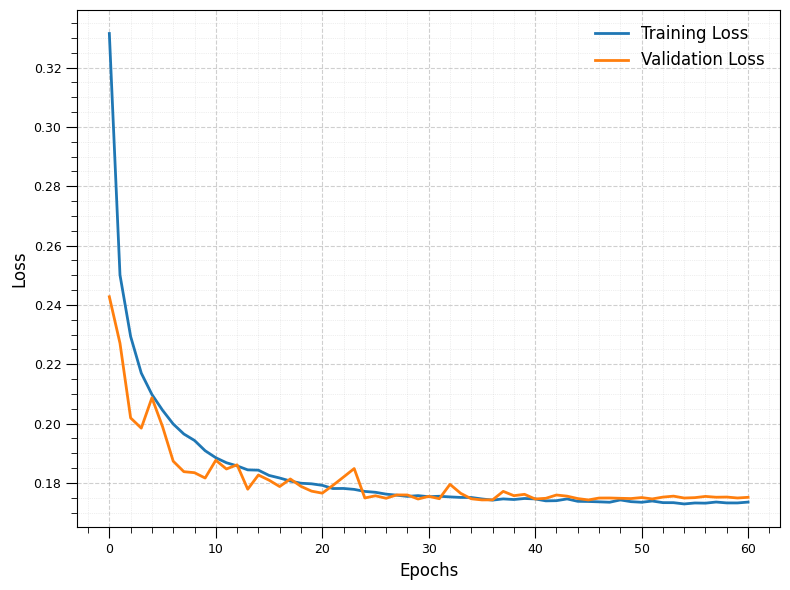

In [20]:
# Loss Plot
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss', lw=2)
plt.plot(history.history['val_loss'], label='Validation Loss', lw=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)

plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.minorticks_on()

plt.tick_params(axis='both', which='major', length=8)
plt.tick_params(axis='both', which='minor', length=4)

plt.grid(True, which='major', linestyle='--', linewidth=0.8, alpha=0.6)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

plt.legend(loc='best', fontsize=12, frameon=False)
plt.tight_layout()

plt.savefig(f'{metrics_path}/training_vs_val_loss.png', dpi=300)
plt.show()

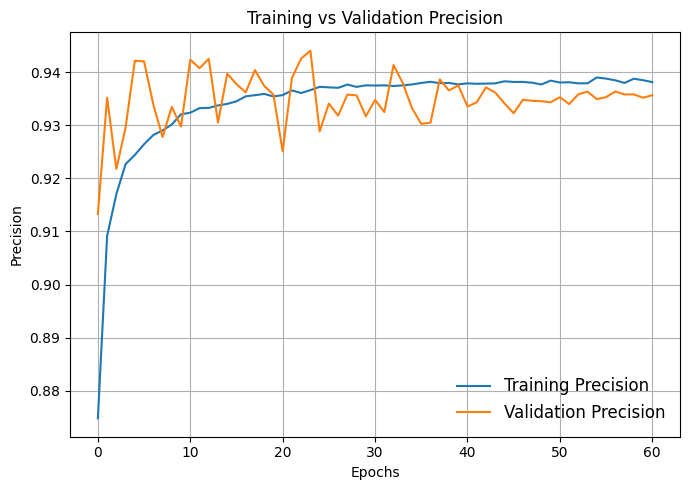

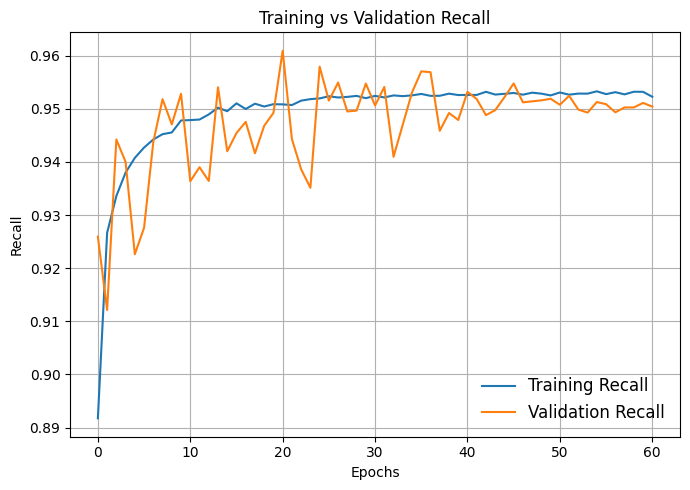

In [21]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Training vs Validation Precision')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_precision.png')
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Training vs Validation Recall')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_recall.png')
plt.show()

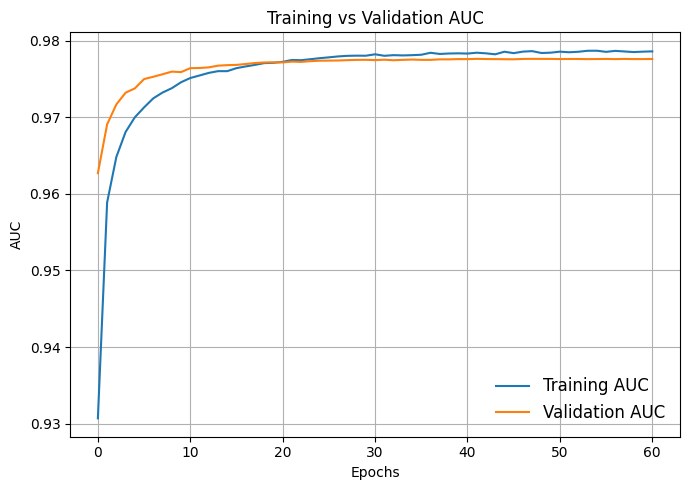

In [22]:
plt.figure(figsize=(7, 5))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Training vs Validation AUC')
plt.legend(loc = 'best', fontsize=12, frameon = False)
plt.grid(True)
plt.tight_layout()
plt.savefig(f'{metrics_path}/training_vs_val_AUC.png')
plt.show()